## Дипломный проект
### Учебный кейс
### «Модель прогнозирования стоимости жилья для агентства недвижимости»

Продолжение.

In [1]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression

import category_encoders as ce

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/cleared_data.zip')
df.head()

,status,baths,fireplace,sqft,zipcode,beds,state,MlsId,target,private_pool,...,stories_2,Heating,Cooling,Parking,lotsize,age_of_the_object,age_of_the_remodeled,schools_av_rating,schools_av_distance,schools_av_grades
0,FOR SALE,3.5,1,2900.0,28387,4.0,NC,1,418000.0,0,...,2.0,AIR,0,0,0.0,5.0,5.0,3.625,5.538,0.342
1,FOR SALE,3.0,0,1947.0,99216,3.0,WA,1,310000.0,0,...,2.0,NO DATA,0,0,5828.0,5.0,5.0,3.000,1.327,0.444
2,FOR SALE,2.0,1,3000.0,90049,3.0,CA,1,2895000.0,1,...,1.0,AIR,1,1,8626.0,63.0,57.0,6.667,1.960,0.289
3,FOR SALE,8.0,1,6457.0,75205,5.0,TX,1,2395000.0,0,...,3.0,AIR,1,1,8220.0,18.0,18.0,9.250,0.753,0.233
4,FOR SALE,3.0,0,1807.0,32908,3.0,FL,1,5000.0,0,...,0.0,NO DATA,0,0,10019.0,39.0,39.0,4.667,4.080,0.311


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371789 entries, 0 to 371788
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                371789 non-null  object 
 1   baths                 371789 non-null  float64
 2   fireplace             371789 non-null  int64  
 3   sqft                  371789 non-null  float64
 4   zipcode               371789 non-null  object 
 5   beds                  371789 non-null  float64
 6   state                 371789 non-null  object 
 7   MlsId                 371789 non-null  int64  
 8   target                371789 non-null  float64
 9   private_pool          371789 non-null  int64  
 10  property_type         371789 non-null  object 
 11  city_2                371789 non-null  object 
 12  stories_2             371789 non-null  float64
 13  Heating               371789 non-null  object 
 14  Cooling               371789 non-null  int64  
 15  

Попробуем поискать неинформативные признаки.

In [4]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in df.columns:
    #наибольшая относительная частота в признаке
    top_freq = df[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = df[col].nunique() / df[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

Неинформативные признаки отсутствуют.

Вспомним распределение целевого признака.

In [5]:
df['target'].describe()

count    3.717890e+05
mean     6.464587e+05
std      1.844327e+06
min      1.000000e+00
25%      1.880000e+05
50%      3.209900e+05
75%      5.850000e+05
max      1.950000e+08
Name: target, dtype: float64

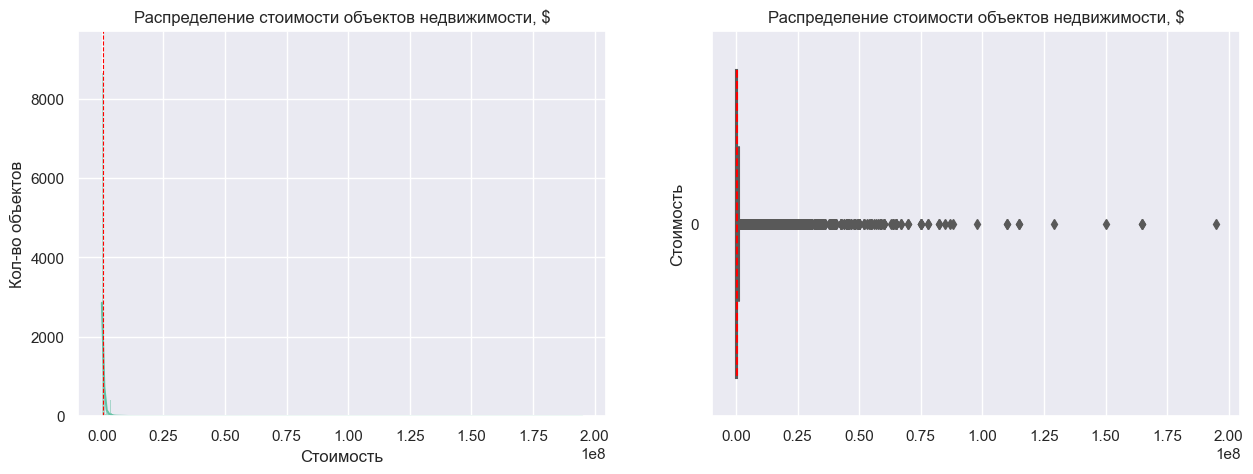

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['target'], kde=True, ax=axes[0])
axes[0].set(xlabel='Стоимость', ylabel='Кол-во объектов')
axes[0].set_title('Распределение стоимости объектов недвижимости, $')
axes[0].axvline(df['target'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df['target'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Стоимость')
axes[1].set_title('Распределение стоимости объектов недвижимости, $')

plt.show()

Удалим выбросы методом межквартильного размаха (Метод Тьюки).

In [7]:
def outliers_iqr_mod(data, feature, log_scale=False, left=1.5, right=1.5):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]    
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(df, 'target')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 37853
Результирующее число записей: 333936


Снова посмотрим на график.

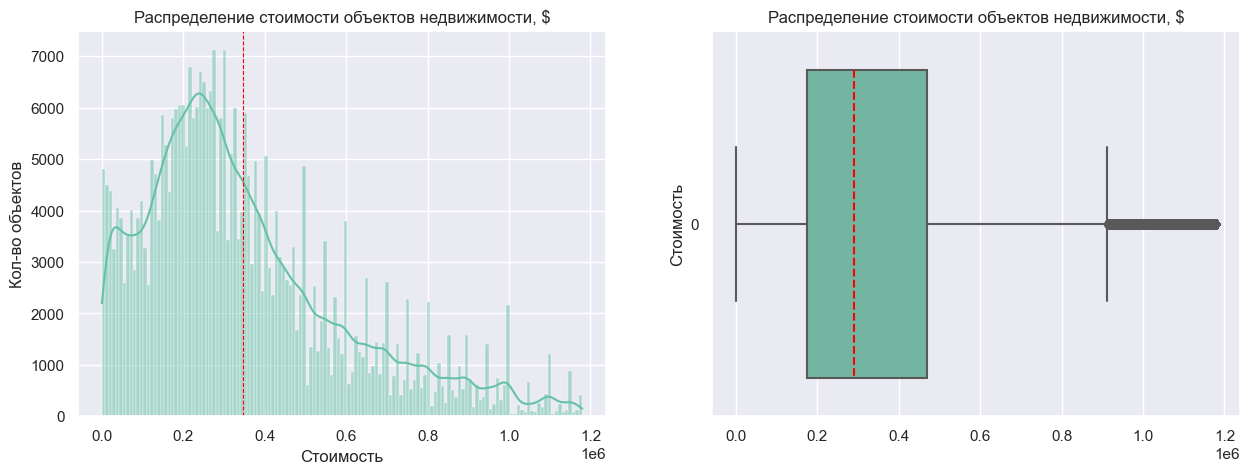

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(cleaned['target'], kde=True, ax=axes[0])
axes[0].set(xlabel='Стоимость', ylabel='Кол-во объектов')
axes[0].set_title('Распределение стоимости объектов недвижимости, $')
axes[0].axvline(cleaned['target'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(cleaned['target'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Стоимость')
axes[1].set_title('Распределение стоимости объектов недвижимости, $')

plt.show()

Выглядит лучше.

In [9]:
df = cleaned

### Статистические тесты и отбор признаков.

### Признак status

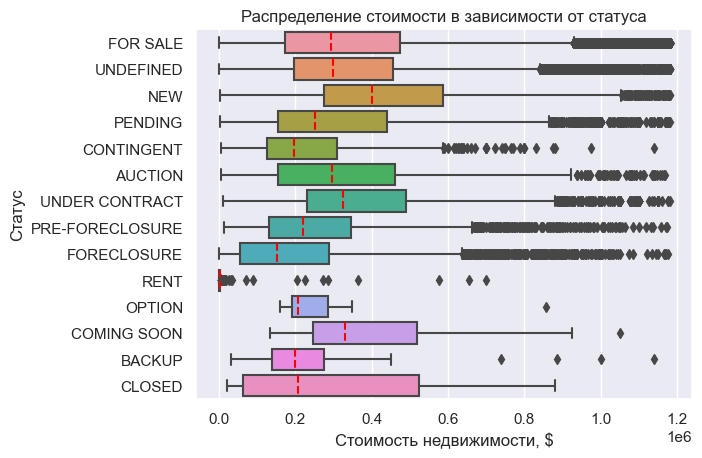

In [10]:
ax = sns.boxplot(df, x='target', y='status', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость недвижимости, $', ylabel='Статус')
plt.title('Распределение стоимости в зависимости от статуса')
plt.show()

Мы видим, что объекты со статусом 'RENT' - аренда сильно ниже в цене объектов с другим статусом, что абсолютно логично, т.к. это не стоимость объекта, а плата за временное пользование.  Учитывая, что поставленная нам задача звучит так: "Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на **продажу** недвижимости, а сервис прогнозирует его стоимость." Объекты этой категории можно удалить из датасета и возможно сделать для этой категории отдельную модель. А для оставшихся категорий проверим подтверждается ли различие в цене статистически.

In [11]:
df_rent = df[df['status'] == 'RENT']
df = df[df['status'] != 'RENT']
display(df_rent.shape[0])
display(df.shape[0])

419

333517

Объектов на самом деле совсем не много.

In [12]:
# задаём уровень значимости
alpha = 0.05

# функция для принятия решения о нормальности
def decision_normality(p):
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. Распределение отлично от нормального')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. Распределение является нормальным')


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.')

### Отличается ли стоимость объекта в зависимости от его статуса?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость объекта не зависит от статуса:

$$ H_0 : μ_1 = μ_2 = μ_3 = ... = μ_n$$

*Альтернативная гипотеза* ($H_1$): стоимость объекта отличается в зависимости от статуса:

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq ... \neq μ_n$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [13]:
# список статусов
ls_status = df['status'].unique()
# список с наборами данных
ls_ds_status = []

for status in ls_status:
    ds_status = df.loc[df['status']==status, 'target']
    ls_ds_status.append(ds_status)
    # проводим тест Шапиро-Уилка
    print(f'{status}:')
    result = stats.shapiro(ds_status)
    decision_normality(result[1])


FOR SALE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
UNDEFINED:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
NEW:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
PENDING:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
CONTINGENT:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
AUCTION:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
UNDER CONTRACT:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
PRE-FORECLOSURE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
FORECLOSURE:
p-value = 0.000
p-

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «tagret»? — Количественный.
* Сколько сравниваемых групп? — Больше 3.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать Критерий Краскела — Уоллиса.

**Проведём тест**

In [14]:
# проводим тест
_, p = stats.kruskal(*ls_ds_status)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: стоимость объекта отличается в зависимости от его статуса.

### Признак fireplace

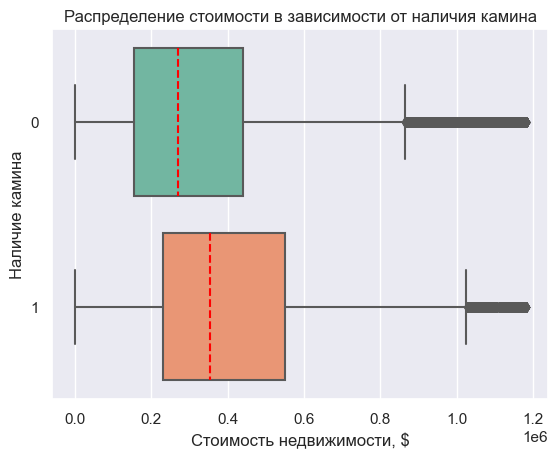

In [15]:
ax = sns.boxplot(df, x='target', y='fireplace', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость недвижимости, $', ylabel='Наличие камина')
plt.title('Распределение стоимости в зависимости от наличия камина')
plt.show()

In [16]:
df_agg = df.groupby('fireplace')['target'].describe().round(2)
print('Соотношение стоимости объекта в зависимости от наличия камина')
df_agg

Соотношение стоимости объекта в зависимости от наличия камина


,count,mean,std,min,25%,50%,75%,max
fireplace,,,,,,,,
0,249681.0,326211.63,242376.84,1.0,154990.0,270000.0,439000.0,1180000.0
1,83836.0,413743.10,247461.83,1.0,232000.0,354900.0,550000.0,1180000.0


Видно, что стоимость объекта недвижимость выше при наличии камина. Определим статистически значимо ли это различие.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость объекта не зависит от наличия камина:

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): стоимость объекта отличается в зависимости от наличия камина:

$$ H_1 : μ_1 \neq μ_2$$

Проверим распределение.

In [17]:
# список
ls_status = df['fireplace'].unique()
# список с наборами данных
ls_ds_status = []

for status in ls_status:
    ds_status = df.loc[df['fireplace']==status, 'target']
    ls_ds_status.append(ds_status)
    # проводим тест Шапиро-Уилка
    if status == 1:
        fireplace = 'С камином'
    else:
        fireplace = 'Без камина'
    print(f'{fireplace}:')
    result = stats.shapiro(ds_status)
    decision_normality(result[1])


С камином:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Без камина:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «tagret»? — Количественный.
* Сколько сравниваемых групп? — 2.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [18]:
# проводим тест
_, p = stats.mannwhitneyu(*ls_ds_status, alternative = 'two-sided')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: есть разница в стоимости объектов в зависимости от наличия камина.

### Признак zipcode

ZIP codes — система почтовых индексов, используемая Почтовой службой США. Сам zipcode не является фактором влияющим на стоимость объекта недвижимости, однако он по сути является георгафической привязкой к местности и по факту дублирует признаки штата и города. Удалим его из набора данных.

In [19]:
df = df.drop(columns=['zipcode'])

### Признак MlsId

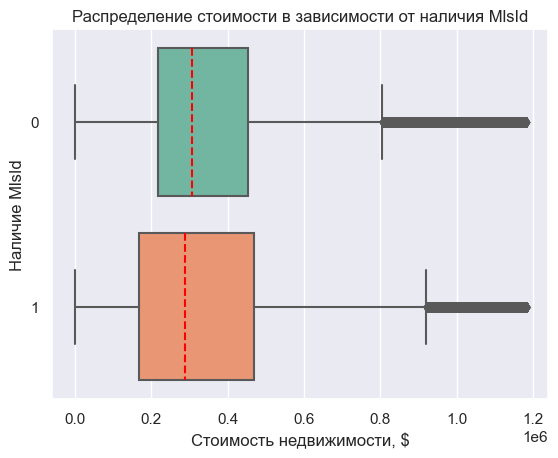

In [20]:
ax = sns.boxplot(df, x='target', y='MlsId', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость недвижимости, $', ylabel='Наличие MlsId')
plt.title('Распределение стоимости в зависимости от наличия MlsId')
plt.show()

Различия есть, но на сколько они значимы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость объекта не зависит от наличия MlsId:

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): стоимость объекта отличается в зависимости от наличия MlsId:

$$ H_1 : μ_1 \neq μ_2$$

Проверим распределение.

In [21]:
# список
ls_status = df['MlsId'].unique()
# список с наборами данных
ls_ds_status = []

for status in ls_status:
    ds_status = df.loc[df['MlsId']==status, 'target']
    ls_ds_status.append(ds_status)
    # проводим тест Шапиро-Уилка
    if status == 1:
        fireplace = 'MlsId заполнен'
    else:
        fireplace = 'MlsId отсутствует'
    print(f'{fireplace}:')
    result = stats.shapiro(ds_status)
    decision_normality(result[1])


MlsId заполнен:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
MlsId отсутствует:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Как и в случае с камином, будем использовать U-критерий Манна — Уитни. 

In [22]:
# проводим тест
_, p = stats.mannwhitneyu(*ls_ds_status, alternative = 'two-sided')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: Стоимость объекта недвижимости зависит от наличия объекта в Multiple listing service.

### Признак private_pool

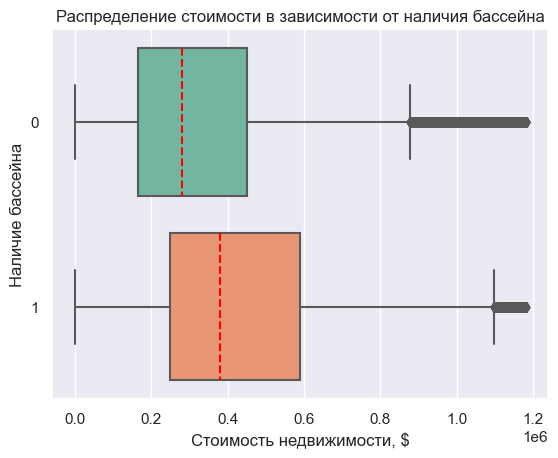

In [23]:
ax = sns.boxplot(df, x='target', y='private_pool', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость недвижимости, $', ylabel='Наличие бассейна')
plt.title('Распределение стоимости в зависимости от наличия бассейна')
plt.show()

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость объекта не зависит от наличия бассейна:

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): стоимость объекта отличается в зависимости от наличия бассейна:

$$ H_1 : μ_1 \neq μ_2$$

Проверим распределение.

In [24]:
# список
ls_status = df['private_pool'].unique()
# список с наборами данных
ls_ds_status = []

for status in ls_status:
    ds_status = df.loc[df['private_pool']==status, 'target']
    ls_ds_status.append(ds_status)
    # проводим тест Шапиро-Уилка
    if status == 1:
        fireplace = 'Бассейн на объекте есть'
    else:
        fireplace = 'Бассейна нет'
    print(f'{fireplace}:')
    result = stats.shapiro(ds_status)
    decision_normality(result[1])


Бассейна нет:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Бассейн на объекте есть:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Используем U-критерий Манна — Уитни. 

In [25]:
# проводим тест
_, p = stats.mannwhitneyu(*ls_ds_status, alternative = 'two-sided')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: наличие бассейна влияет на цену объекта недвижимости.

### Признак Heating

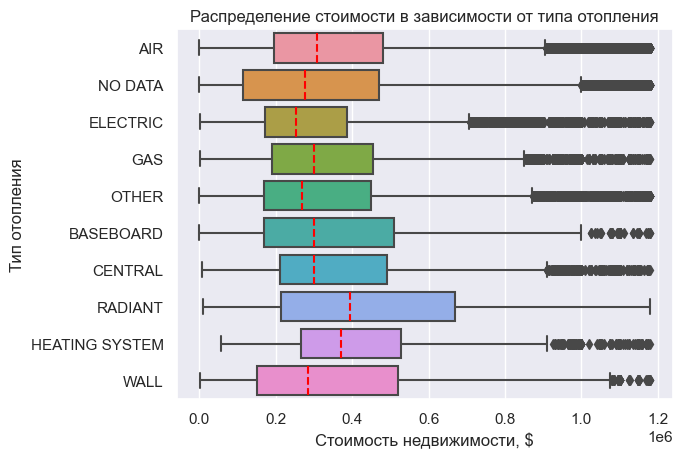

In [26]:
ax = sns.boxplot(df, x='target', y='Heating', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость недвижимости, $', ylabel='Тип отопления')
plt.title('Распределение стоимости в зависимости от типа отопления')
plt.show()

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость объекта не зависит от типа используемого отопления:

$$ H_0 : μ_1 = μ_2 = μ_3 = ... = μ_n$$

*Альтернативная гипотеза* ($H_1$): стоимость объекта отличается в зависимости от типа используемого отопления:

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq ... \neq μ_n$$

Проверим распределение.

In [27]:
# список 
ls_status = df['Heating'].unique()
# список с наборами данных
ls_ds_status = []

for status in ls_status:
    ds_status = df.loc[df['Heating']==status, 'target']
    ls_ds_status.append(ds_status)
    # проводим тест Шапиро-Уилка
    print(f'{status}:')
    result = stats.shapiro(ds_status)
    decision_normality(result[1])


AIR:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
NO DATA:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
ELECTRIC:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
GAS:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
OTHER:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
BASEBOARD:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
CENTRAL:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
RADIANT:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
HEATING SYSTEM:
p-value = 0.000
p-значение меньше, чем 

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «tagret»? — Количественный.
* Сколько сравниваемых групп? — Больше 3.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать Критерий Краскела — Уоллиса.

**Проведём тест**

In [28]:
# проводим тест
_, p = stats.kruskal(*ls_ds_status)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: есть различия в стоимости объектов недвижимости в зависимости от типа используемого отопления.

### Призанак Cooling

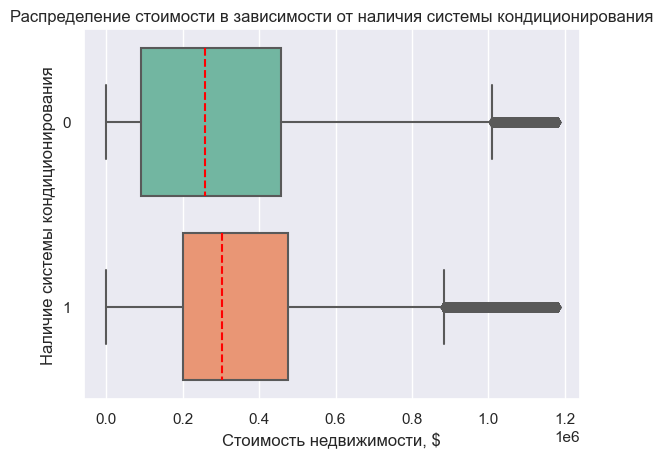

In [29]:
ax = sns.boxplot(df, x='target', y='Cooling', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость недвижимости, $', ylabel='Наличие системы кондиционирования')
plt.title('Распределение стоимости в зависимости от наличия системы кондиционирования')
plt.show()

Небольшое различие есть. Значимо ли оно?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость объекта не зависит от наличия системы кондиционирования:

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): стоимость объекта отличается в зависимости от наличия системы кондиционирования:

$$ H_1 : μ_1 \neq μ_2$$

Проверим распределение.

In [30]:
# список
ls_status = df['Cooling'].unique()
# список с наборами данных
ls_ds_status = []

for status in ls_status:
    ds_status = df.loc[df['Cooling']==status, 'target']
    ls_ds_status.append(ds_status)
    # проводим тест Шапиро-Уилка
    if status == 1:
        fireplace = 'Система кондиционирования на объекте есть'
    else:
        fireplace = 'Системы кондиционирования нет'
    print(f'{fireplace}:')
    result = stats.shapiro(ds_status)
    decision_normality(result[1])


Системы кондиционирования нет:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Система кондиционирования на объекте есть:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Используем U-критерий Манна — Уитни. 

In [31]:
# проводим тест
_, p = stats.mannwhitneyu(*ls_ds_status, alternative = 'two-sided')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: цена объекта отличается в зависимости от того есть ли на объекте система кондиционирования.

### Признак Parking

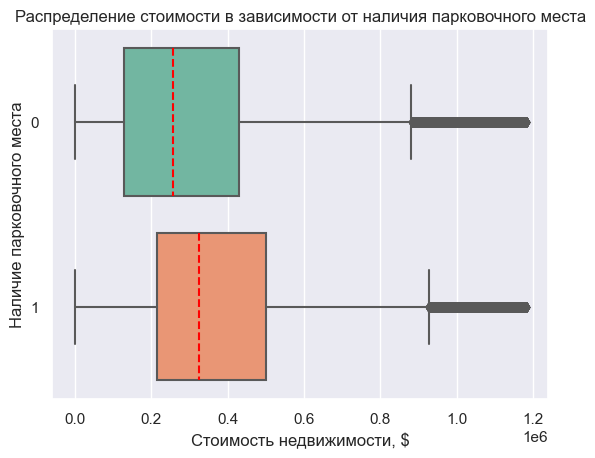

In [32]:
ax = sns.boxplot(df, x='target', y='Parking', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость недвижимости, $', ylabel='Наличие парковочного места')
plt.title('Распределение стоимости в зависимости от наличия парковочного места')
plt.show()

Проверим насколько значимо различие.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость объекта не зависит от наличия парковочного места:

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): стоимость объекта отличается в зависимости от наличия парковочного места:

$$ H_1 : μ_1 \neq μ_2$$

Проверим распределение.

In [33]:
# список
ls_status = df['Parking'].unique()
# список с наборами данных
ls_ds_status = []

for status in ls_status:
    ds_status = df.loc[df['Parking']==status, 'target']
    ls_ds_status.append(ds_status)
    # проводим тест Шапиро-Уилка
    if status == 1:
        fireplace = 'Парковочное место есть'
    else:
        fireplace = 'Парковочного места нет'
    print(f'{fireplace}:')
    result = stats.shapiro(ds_status)
    decision_normality(result[1])


Парковочного места нет:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Парковочное место есть:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Используем U-критерий Манна — Уитни. 

In [34]:
# проводим тест
_, p = stats.mannwhitneyu(*ls_ds_status, alternative = 'two-sided')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: есть различия в стоимости объектов недвижимости в зависимости он наличия парковочного места.

### Признак property_type

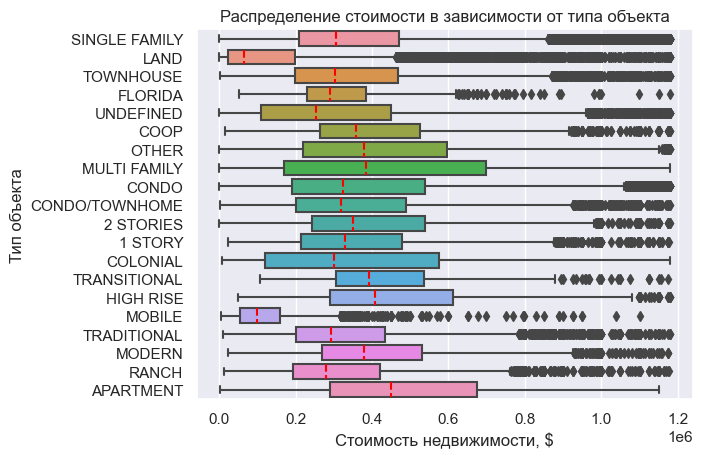

In [35]:
ax = sns.boxplot(df, x='target', y='property_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость недвижимости, $', ylabel='Тип объекта')
plt.title('Распределение стоимости в зависимости от типа объекта')
plt.show()

Проверим насколько значимо различие.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость объекта не зависит от типа объекта:

$$ H_0 : μ_1 = μ_2 = μ_3 = ... = μ_n$$

*Альтернативная гипотеза* ($H_1$): стоимость объекта отличается в зависимости от типа объекта:

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq ... \neq μ_n$$

Проверим распределение.

In [36]:
# список 
ls_status = df['Heating'].unique()
# список с наборами данных
ls_ds_status = []

for status in ls_status:
    ds_status = df.loc[df['Heating']==status, 'target']
    ls_ds_status.append(ds_status)
    # проводим тест Шапиро-Уилка
    print(f'{status}:')
    result = stats.shapiro(ds_status)
    decision_normality(result[1])


AIR:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
NO DATA:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
ELECTRIC:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
GAS:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
OTHER:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
BASEBOARD:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
CENTRAL:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
RADIANT:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
HEATING SYSTEM:
p-value = 0.000
p-значение меньше, чем 

Для проверки нашей гипотезы можно использовать Критерий Краскела — Уоллиса.

**Проведём тест**

In [37]:
# проводим тест
_, p = stats.kruskal(*ls_ds_status)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: стоимость объекта недвижимости различается в зависимости от его типа.

### Признак state

In [38]:
df['state'].value_counts(normalize=True) * 100

state
FL    31.223596
TX    23.105869
NC     6.190389
TN     5.096892
CA     4.995248
NY     4.712204
OH     3.650489
WA     3.593820
IL     2.444853
NV     2.354303
GA     1.812801
CO     1.757032
PA     1.562439
MI     1.520762
DC     1.124980
AZ     0.993353
IN     0.951676
OR     0.766977
UT     0.360401
MA     0.326820
MD     0.280046
MO     0.246464
VT     0.243766
VA     0.213782
WI     0.133726
NJ     0.126830
ME     0.075558
IA     0.070161
KY     0.026685
OK     0.014692
MS     0.011394
SC     0.008395
MT     0.002099
DE     0.001199
AL     0.000300
Name: proportion, dtype: float64

In [39]:
# подготовим данные, возьмем 10 наиболее популярных
popular = df['state'].value_counts().nlargest(10).index
df_pop = df[['state', 'target']].copy()
df_pop['popular'] = df_pop['state'].apply(lambda x: 1 if x in popular else 0)
df_pop = df_pop[df_pop['popular'] == 1]

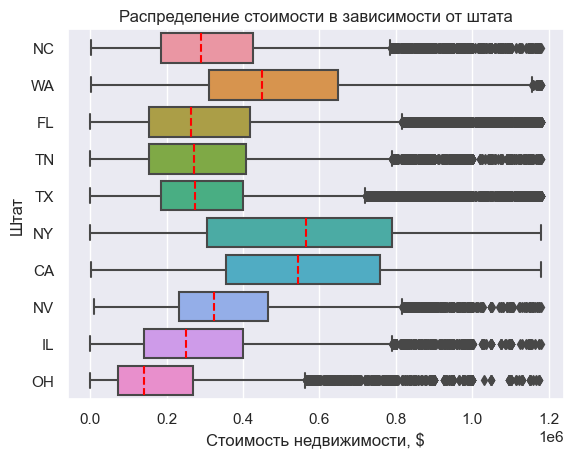

In [40]:
ax = sns.boxplot(df_pop, x='target', y='state', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Стоимость недвижимости, $', ylabel='Штат')
plt.title('Распределение стоимости в зависимости от штата')
plt.show()

На графике видно различие в стоимости. Проверим насколько оно значимо.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): стоимость объекта не зависит от штата в которым находится объект:

$$ H_0 : μ_1 = μ_2 = μ_3 = ... = μ_n$$

*Альтернативная гипотеза* ($H_1$): стоимость объекта отличается в зависимости от штата в котором находится объект:

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq ... \neq μ_n$$

Проверим распределение.

In [41]:
# список 
ls_status = df_pop['state'].unique()
# список с наборами данных
ls_ds_status = []

for status in ls_status:
    ds_status = df_pop.loc[df_pop['state']==status, 'target']
    ls_ds_status.append(ds_status)
    # проводим тест Шапиро-Уилка
    print(f'{status}:')
    result = stats.shapiro(ds_status)
    decision_normality(result[1])


NC:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
WA:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
FL:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
TN:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
TX:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
NY:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
CA:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
NV:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
IL:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределен

Для проверки нашей гипотезы можно использовать Критерий Краскела — Уоллиса.

**Проведём тест**

In [42]:
# проводим тест
_, p = stats.kruskal(*ls_ds_status)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: стоимость объекта недвижимости зависит от штата в котором он расположен.

### Признак baths

In [43]:
df['baths'].describe()

count    333517.000000
mean          2.640222
std           1.152304
min           0.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          64.000000
Name: baths, dtype: float64

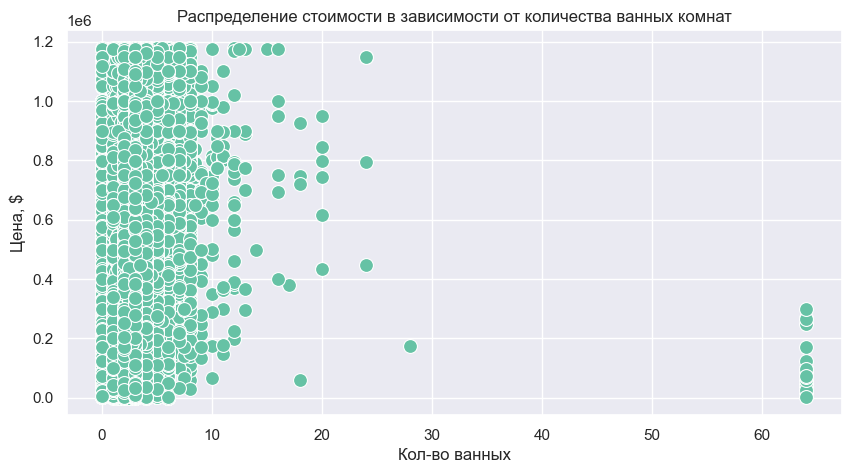

In [44]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='baths',
    y='target',
    s=100
)
scatterplot.set(xlabel='Кол-во ванных', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от количества ванных комнат')
plt.show();

Визуально видно, что у объекты c числом ванных комнат более 10 отделены от основной группы объектов. Посмотрим сколько их.

In [45]:
df[df['baths'] > 10].shape[0]

125

Видится разумным удаление этих объектов.

In [46]:
df = df[df['baths'] <= 10]

Посмотрим на результат

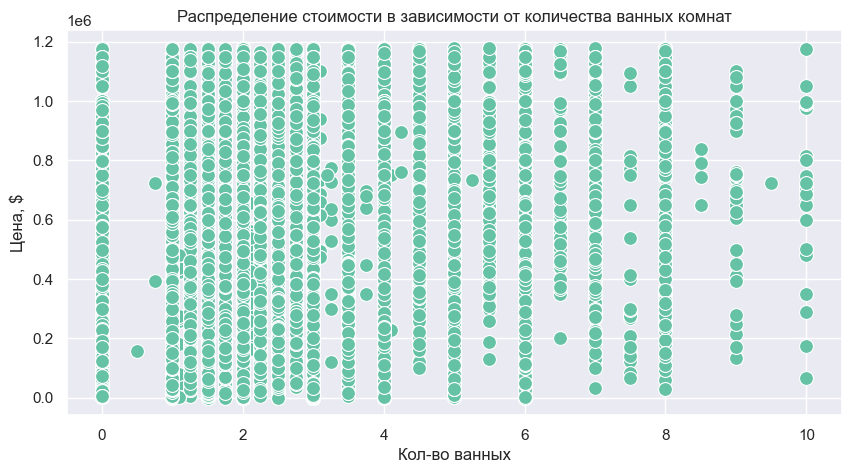

In [47]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='baths',
    y='target',
    s=100
)
scatterplot.set(xlabel='Кол-во ванных', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от количества ванных комнат')
plt.show();

По графику связь с целевым признаком не просматривается. 

### Признак beds

In [48]:
df['beds'].describe()

count    333392.000000
mean          3.140357
std           0.903814
min           0.000000
25%           3.000000
50%           3.000000
75%           3.000000
max          44.000000
Name: beds, dtype: float64

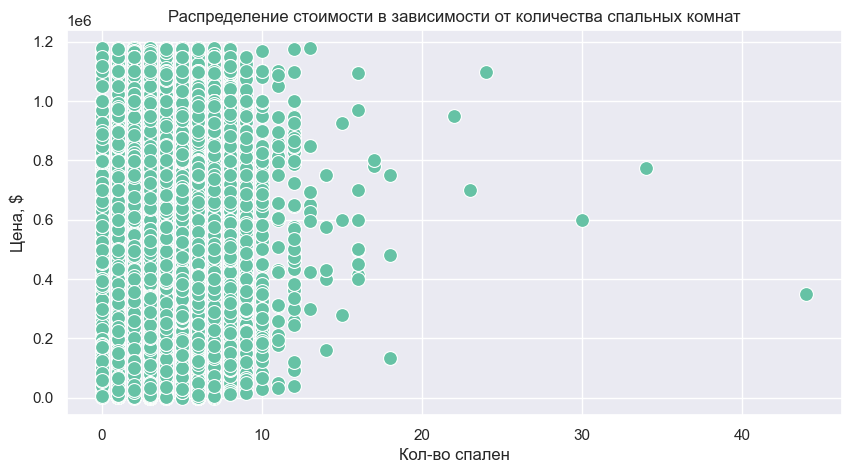

In [49]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='beds',
    y='target',
    s=100
)
scatterplot.set(xlabel='Кол-во спален', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от количества спальных комнат')
plt.show();

Мы так же видим явное отделение группы объектов при увеличении числа спален более 12.

In [50]:
df[df['beds'] > 12].shape[0]

47

In [51]:
# удалим
df = df[df['beds'] <= 12]

Посмотрим на результат

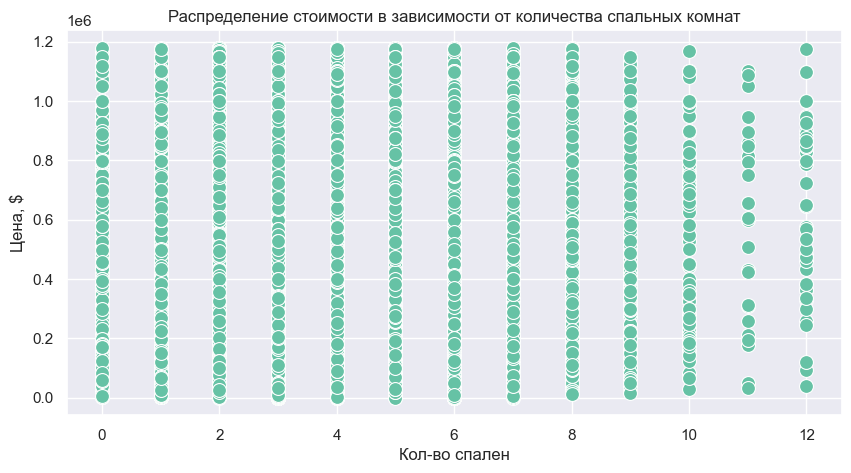

In [52]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='beds',
    y='target',
    s=100
)
scatterplot.set(xlabel='Кол-во спален', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от количества спальных комнат')
plt.show();

Связь не просматривается.

### Признак sqft

In [53]:
df['sqft'].describe()

count    3.333450e+05
mean     6.676628e+03
std      1.589720e+06
min      0.000000e+00
25%      1.254000e+03
50%      1.807000e+03
75%      2.319000e+03
max      7.959794e+08
Name: sqft, dtype: float64

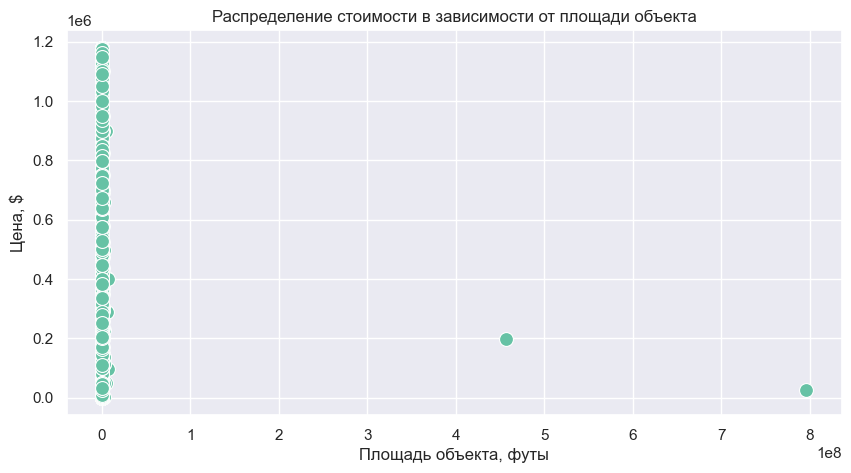

In [54]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='sqft',
    y='target',
    s=100
)
scatterplot.set(xlabel='Площадь объекта, футы', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от площади объекта')
plt.show();

Требуется очистка от выбросов.

In [55]:
outliers, cleaned = outliers_iqr_mod(df, 'sqft')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 15080
Результирующее число записей: 318265


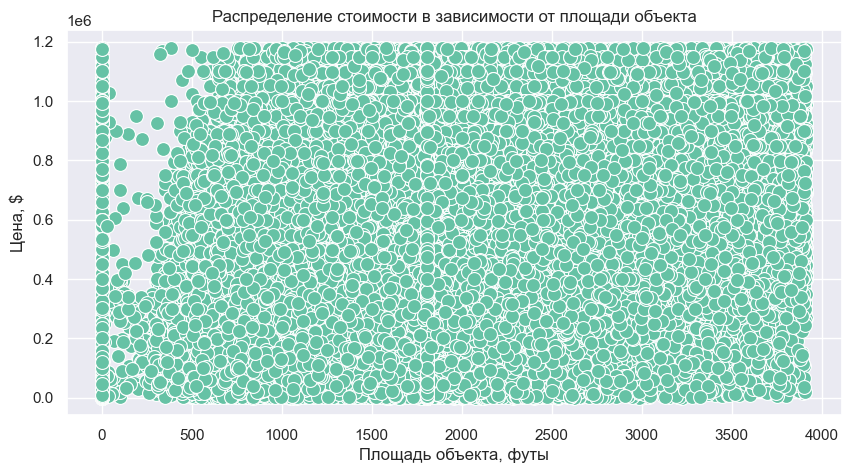

In [56]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=cleaned,
    x='sqft',
    y='target',
    s=100
)
scatterplot.set(xlabel='Площадь объекта, футы', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от площади объекта')
plt.show();

Отлично, сработало.

На графике не прослеживается связь. Для объектов с любой площадью есть все уровни цен.

In [57]:
df = cleaned

### Признак stories_2

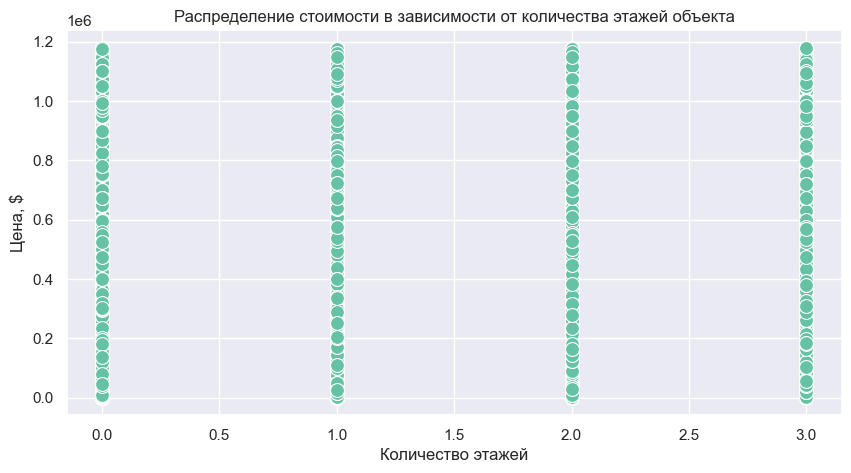

In [58]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='stories_2',
    y='target',
    s=100
)
scatterplot.set(xlabel='Количество этажей', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от количества этажей объекта')
plt.show();

Визуально зависимость не прослеживается.

### Признак lotsize

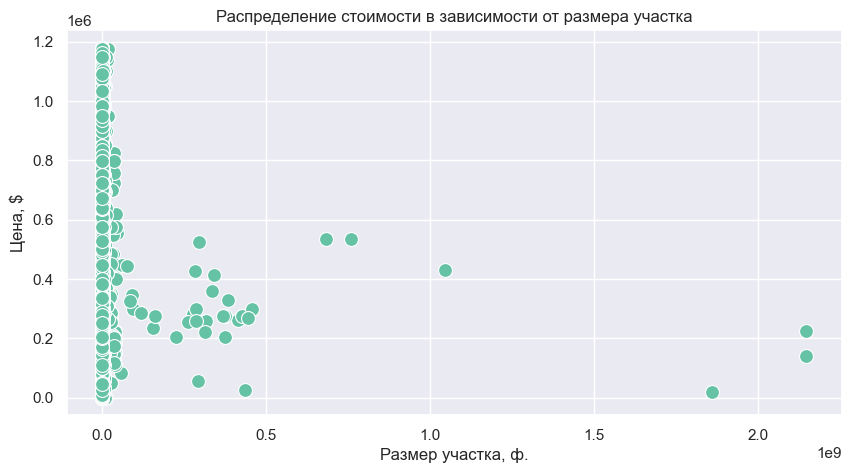

In [59]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='lotsize',
    y='target',
    s=100
)
scatterplot.set(xlabel='Размер участка, ф.', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от размера участка')
plt.show();

Требуется очистка от выбросов.

In [60]:
outliers, cleaned = outliers_iqr_mod(df, 'lotsize')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 31260
Результирующее число записей: 287005


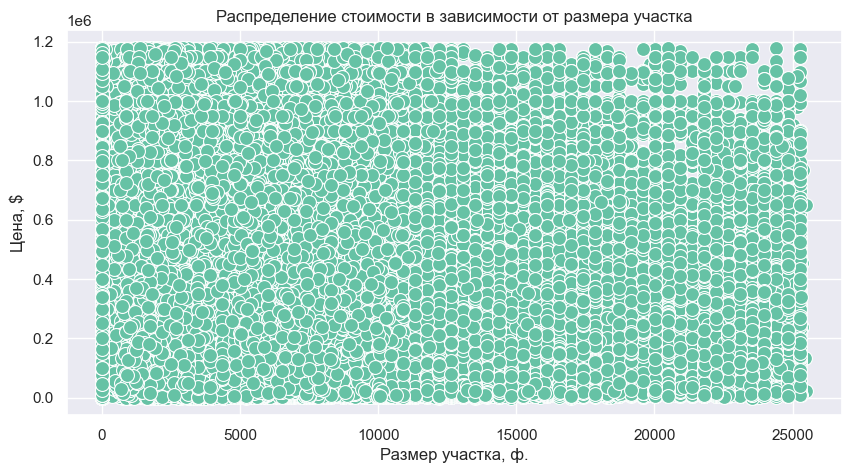

In [61]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=cleaned,
    x='lotsize',
    y='target',
    s=100
)
scatterplot.set(xlabel='Размер участка, ф.', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от размера участка')
plt.show();

Зависимости не прослеживается.

In [62]:
df = cleaned

### Признак age_of_the_object

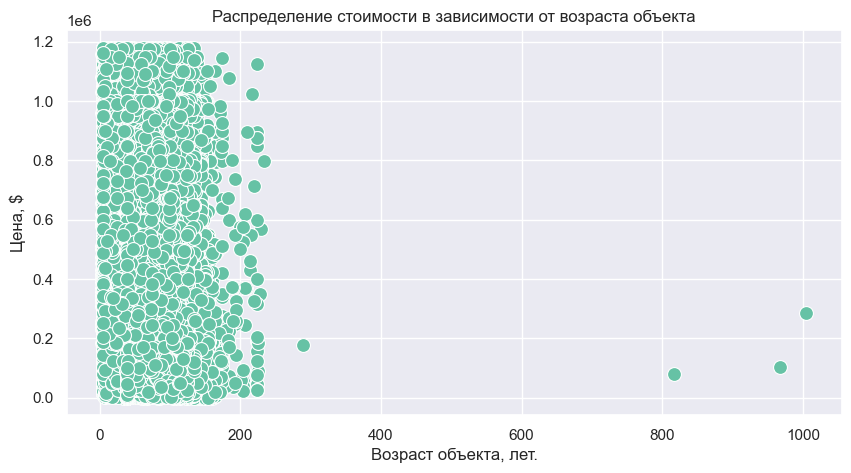

In [63]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='age_of_the_object',
    y='target',
    s=100
)
scatterplot.set(xlabel='Возраст объекта, лет.', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от возраста объекта')
plt.show();

In [64]:
df[df['age_of_the_object'] > 200].shape[0]

48

In [65]:
df = df[df['age_of_the_object'] <= 200]

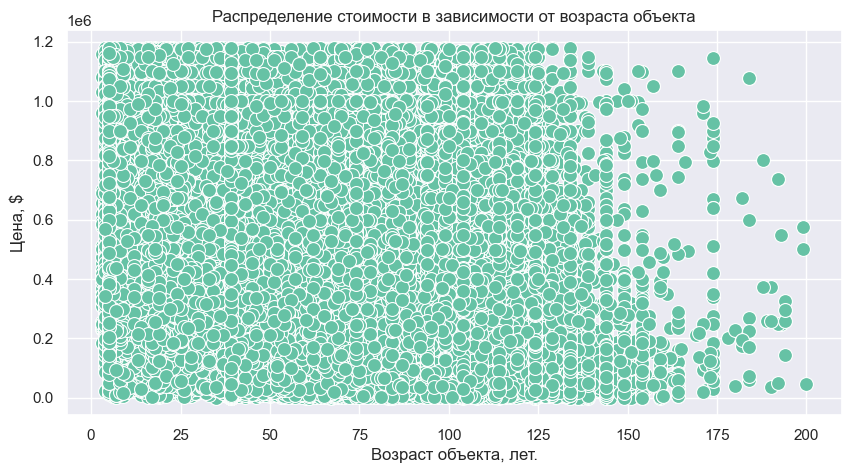

In [66]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='age_of_the_object',
    y='target',
    s=100
)
scatterplot.set(xlabel='Возраст объекта, лет.', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от возраста объекта')
plt.show();

### Признак age_of_the_remodeled

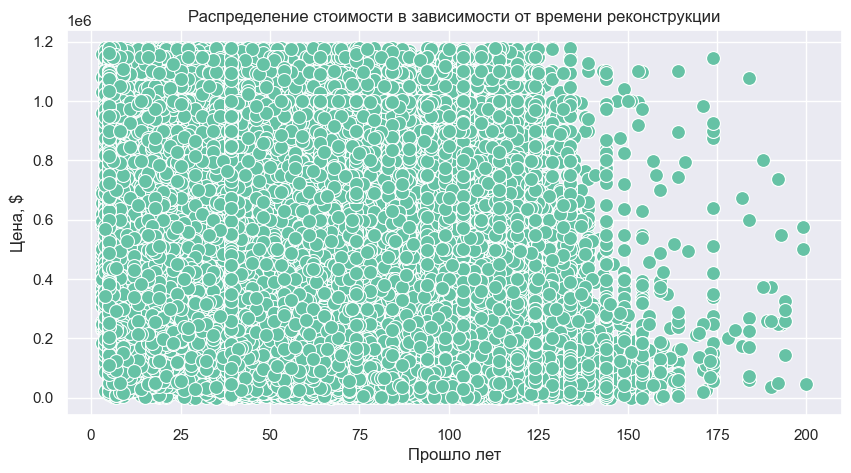

In [67]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='age_of_the_remodeled',
    y='target',
    s=100
)
scatterplot.set(xlabel='Прошло лет', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от времени реконструкции')
plt.show();

По возрасту объекта и времени прошедшему с последней реконструкции картина примерно похожа. С увеличением возраста объектов становится меньше, но какой либо явной зависимости не прослеживается.

### Признак schools_av_rating

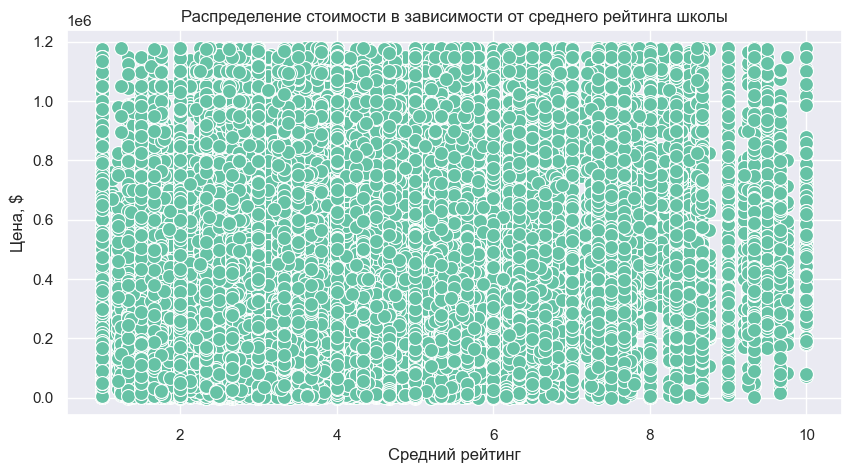

In [68]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='schools_av_rating',
    y='target',
    s=100
)
scatterplot.set(xlabel='Средний рейтинг', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от среднего рейтинга школы')
plt.show();

### Признак schools_av_distance

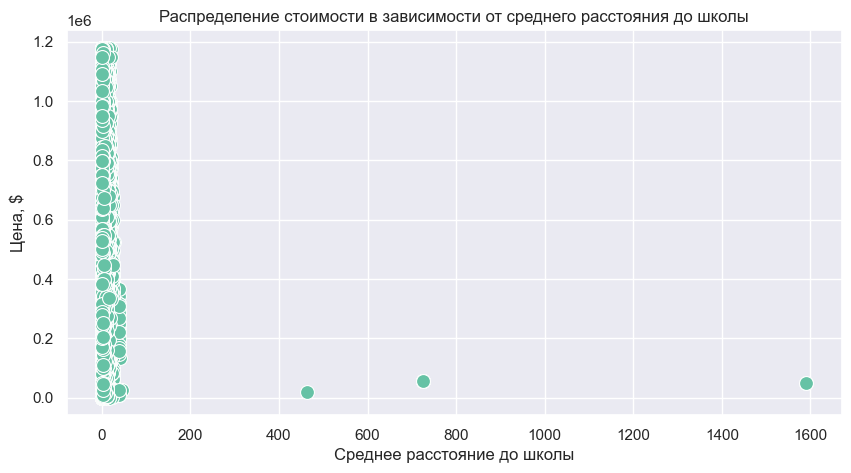

In [69]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='schools_av_distance',
    y='target',
    s=100
)
scatterplot.set(xlabel='Среднее расстояние до школы', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от среднего расстояния до школы')
plt.show();

In [70]:
df[df['schools_av_distance'] > 20].shape[0]

443

In [71]:
df = df[df['schools_av_distance'] <= 20]

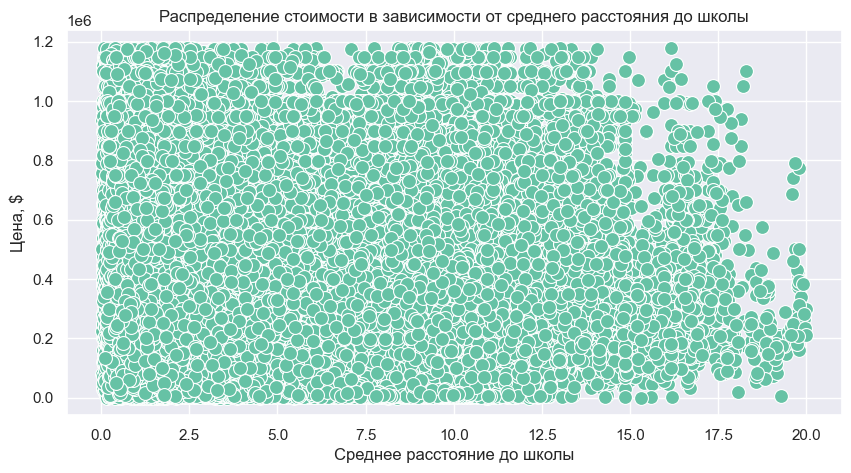

In [72]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='schools_av_distance',
    y='target',
    s=100
)
scatterplot.set(xlabel='Среднее расстояние до школы', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от среднего расстояния до школы')
plt.show();

### Признак schools_av_grades

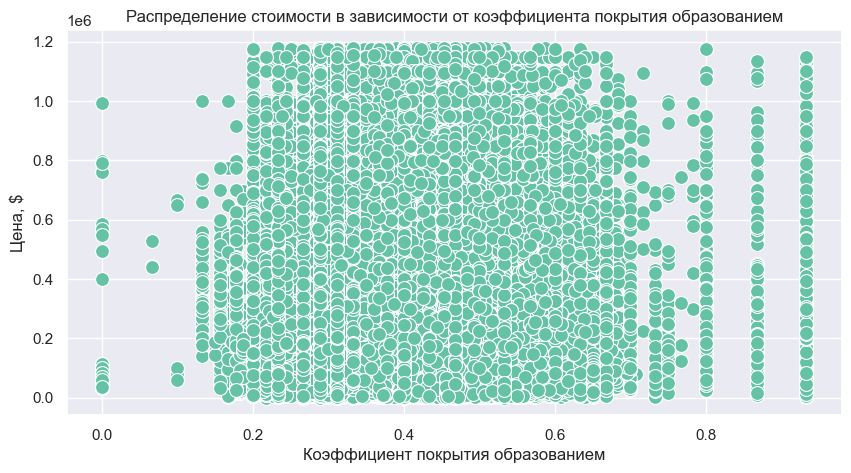

In [73]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=df,
    x='schools_av_grades',
    y='target',
    s=100
)
scatterplot.set(xlabel='Коэффициент покрытия образованием', ylabel='Цена, $')
plt.title('Распределение стоимости в зависимости от коэффициента покрытия образованием')
plt.show();

По признакам, которые нам удалось получить из признака schools, какой либо явной зависимости не прослеживается. При этом большинство объектов покрываются детским образованием в диапазоне коэффициетов 0.2 - 0.7, что представляется вполне логичным.

Посмотрим на корреляцию числовых признаков.

<Axes: >

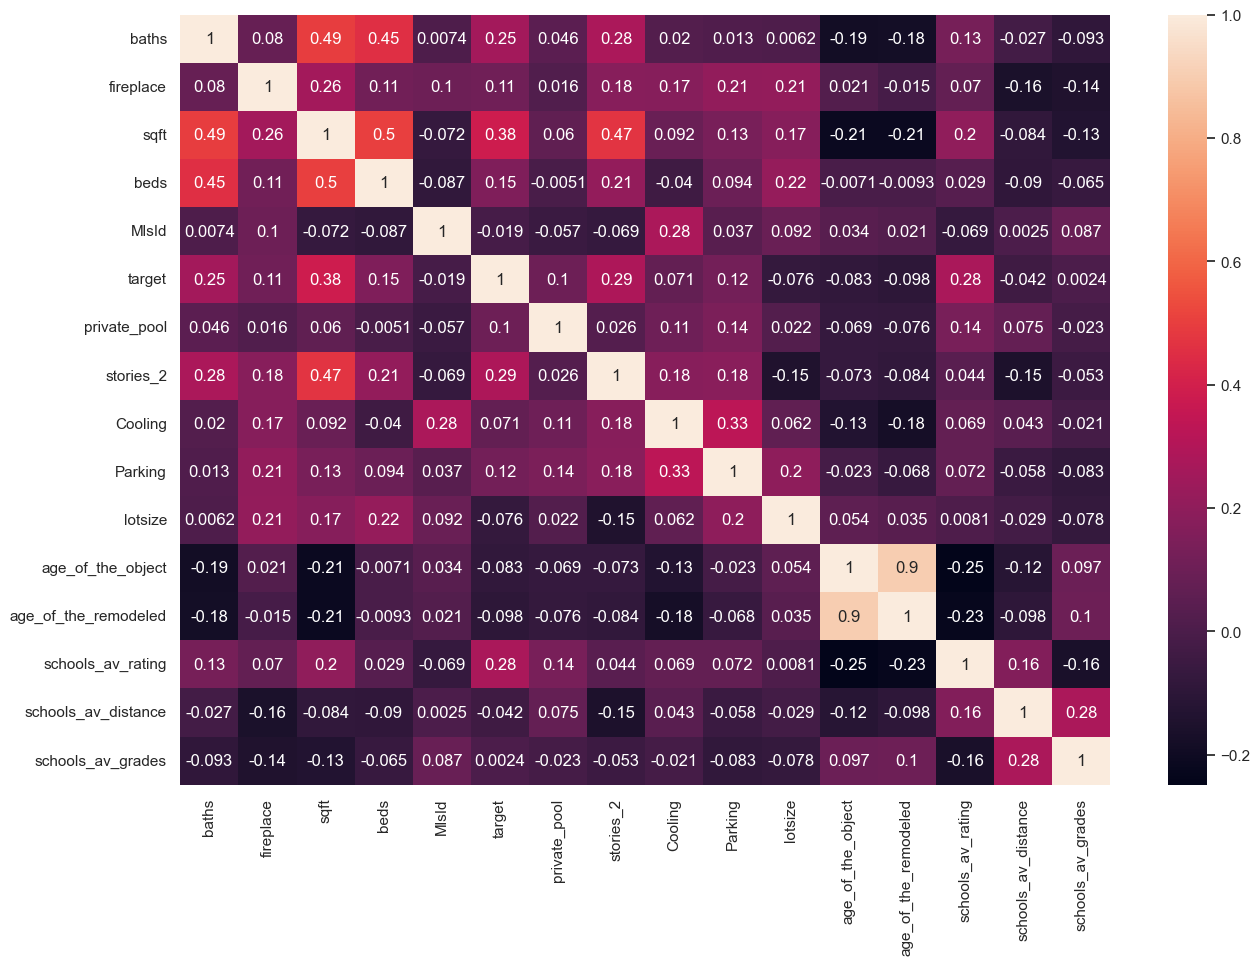

In [74]:
matrix_corr = df.corr(numeric_only=True)
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(matrix_corr, annot=True)

In [75]:
# найдем признаки с коэффициентом корреляции больше 0.7
max_val = 0.7
n = 1
for i in matrix_corr.columns:
    ind = 0
    fl = 0
    for j in matrix_corr[i]:
        if i == matrix_corr.index[ind]:
            fl = 1
        elif fl == 1:
            if abs(j) > max_val:
                print(f'Пара {n}:')
                print(f'Признак 1: {i}')
                print(f'Признак 2: {matrix_corr.index[ind]}')
                print(f'Коэффициент корреляции: {round(j, 2)}')
                print('')
                n += 1
        ind += 1
        


Пара 1:
Признак 1: age_of_the_object
Признак 2: age_of_the_remodeled
Коэффициент корреляции: 0.9



Ожидаемо получили высокую корреляцию между признаками age_of_the_object и age_of_the_remodeled. Удалим age_of_the_object, т.к. у age_of_the_remodeled выше корреляция с целевым признаком.

In [76]:
df = df.drop(columns=['age_of_the_object'])

Сохраним полученный датасет.

In [77]:
compression_opts = dict(method='zip', archive_name='baseline.csv')  
df.to_csv('data/baseline.zip', index=False, compression=compression_opts)

In [78]:
# Посмотрим на количество уникальных значений признаков
object_columns = [s for s in df.columns if df[s].dtypes == 'object']

for column in object_columns:
 print(f"Число уникальных значений призкака '{column}':", df[column].nunique())

Число уникальных значений призкака 'status': 13
Число уникальных значений призкака 'state': 34
Число уникальных значений призкака 'property_type': 20
Число уникальных значений призкака 'city_2': 1455
Число уникальных значений призкака 'Heating': 10


Разделим датасет

In [79]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

Применим Binary Encoding для property_type, штата и города, для остальных признаков OneHot Encoding

In [80]:
# Binary Encoding
columns_to_change = ['property_type', 'state', 'city_2']

# кодируем
bin_encoder = ce.BinaryEncoder(cols=columns_to_change)
type_bin = bin_encoder.fit_transform(X_train[columns_to_change])
X_train = pd.concat([X_train, type_bin], axis=1)

# сразу удалим лишнее
X_train = X_train.drop(columns=columns_to_change)

# тестовые данные
type_bin = bin_encoder.transform(X_test[columns_to_change])
X_test = pd.concat([X_test, type_bin], axis=1)

# сразу удалим лишнее
X_test = X_test.drop(columns=columns_to_change)


In [81]:
# OneHot Encoding
columns_to_change = ['status', 'Heating']

# кодируем
hot_encoder = ce.OneHotEncoder(cols=columns_to_change)
type_hot = hot_encoder.fit_transform(X_train[columns_to_change])
X_train = pd.concat([X_train, type_hot], axis=1)

# сразу удалим лишнее
X_train = X_train.drop(columns=columns_to_change)

# тестовые данные
type_hot = hot_encoder.transform(X_test[columns_to_change])
X_test = pd.concat([X_test, type_hot], axis=1)

# сразу удалим лишнее
X_test = X_test.drop(columns=columns_to_change)


In [82]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229211 entries, 214621 to 158526
Data columns (total 59 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   baths                 229211 non-null  float64
 1   fireplace             229211 non-null  int64  
 2   sqft                  229211 non-null  float64
 3   beds                  229211 non-null  float64
 4   MlsId                 229211 non-null  int64  
 5   private_pool          229211 non-null  int64  
 6   stories_2             229211 non-null  float64
 7   Cooling               229211 non-null  int64  
 8   Parking               229211 non-null  int64  
 9   lotsize               229211 non-null  float64
 10  age_of_the_remodeled  229211 non-null  float64
 11  schools_av_rating     229211 non-null  float64
 12  schools_av_distance   229211 non-null  float64
 13  schools_av_grades     229211 non-null  float64
 14  property_type_0       229211 non-null  int64  
 15  

Стандартизируем

In [83]:
scaler = preprocessing.StandardScaler().set_output(transform='pandas')
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Попробуем отобрать 30 признаков методом лучших переменных (SelectKBest) и попробуем построить модель на этих признаках и на всех.

In [84]:
selector = SelectKBest(f_regression, k=30).set_output(transform='pandas')
X_train_30 = selector.fit_transform(X_train_scaled, y_train)


In [85]:
X_train_30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229211 entries, 214621 to 158526
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   baths                 229211 non-null  float64
 1   fireplace             229211 non-null  float64
 2   sqft                  229211 non-null  float64
 3   beds                  229211 non-null  float64
 4   private_pool          229211 non-null  float64
 5   stories_2             229211 non-null  float64
 6   Cooling               229211 non-null  float64
 7   Parking               229211 non-null  float64
 8   lotsize               229211 non-null  float64
 9   age_of_the_remodeled  229211 non-null  float64
 10  schools_av_rating     229211 non-null  float64
 11  schools_av_distance   229211 non-null  float64
 12  property_type_0       229211 non-null  float64
 13  property_type_2       229211 non-null  float64
 14  property_type_3       229211 non-null  float64
 15  

In [86]:
# на 30 лучших
lr_30 = linear_model.LinearRegression()
lr_30.fit(X_train_30, y_train)
y_train_30_pred = lr_30.predict(X_train_30)
y_test_30_pred = lr_30.predict(X_test_scaled[X_train_30.columns])

In [87]:
# на всех
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

В качестве метрик будем использовать:
1. Средняя абсолютная ошибка в процентах — MAPE (Mean Absolute Percent Error). Легко интерпретировать.
2. Коэффициент детерминации - $R^{2}$. Можно сравнивать модели, обученные на разных признаках. Легко оценить качество модели: измеряется от $-\infty$ до 1.

In [88]:
# Посчитаем метрики

r2_lr_30_train = metrics.r2_score(y_train, y_train_30_pred)
r2_lr_30_test = metrics.r2_score(y_test, y_test_30_pred)
mape_lr_30_train = metrics.mean_absolute_percentage_error(y_train, y_train_30_pred)
mape_lr_30_test = metrics.mean_absolute_percentage_error(y_test, y_test_30_pred)
print('Метрики модели построенной на 30 лучших признаках:')
print('R2:')
print(f'Train: {r2_lr_30_train :.3f}')
print(f'Test: {r2_lr_30_test :.3f}')
print('MAPE:')
print(f'Train: {mape_lr_30_train :.3f}')
print(f'Test: {mape_lr_30_test :.3f}')
print()

r2_lr_train = metrics.r2_score(y_train, y_train_pred)
r2_lr_test = metrics.r2_score(y_test, y_test_pred)
mape_lr_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
mape_lr_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
print('Метрики модели построенной на всех признаках:')
print('R2:')
print(f'Train: {r2_lr_train :.3f}')
print(f'Test: {r2_lr_test :.3f}')
print('MAPE:')
print(f'Train: {mape_lr_train :.3f}')
print(f'Test: {mape_lr_test :.3f}')

Метрики модели построенной на 30 лучших признаках:
R2:
Train: 0.348
Test: 0.347
MAPE:
Train: 11.345
Test: 5.003

Метрики модели построенной на всех признаках:
R2:
Train: 0.369
Test: 0.370
MAPE:
Train: 10.893
Test: 4.460


Метрики модели построенной на всех признаках несколько лучше, чем у модели построенной на 30 признаках отобранных методом лучших переменных (SelectKBest). Далее для построения моделей будем использовать все признаки где это возможно. Подозреваю, что посчитать модель полиномиальной регрессии на всех признаках будет проблематично. На этом baseline можно считать законченным.  
Продолжение в файле [3_final_model.ipynb](3_final_model.ipynb)